# Denoising Auto-Encoder with BatchNorm 


Reference:
1. https://juejin.cn/post/7265310874488520765
2. https://www.infoq.cn/article/dwrm4qcmrluzazp2hvgd

In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.functional as F 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [2]:
# Hyperparams 
batch_size = 100 
input_dim = 28 * 28 # image pixel size 
learning_rate  = 1E-2
num_epochs = 10
image_width = 28 
blur_size = 5

In [3]:
# define data class 
class ReconstructedMNIST(torchvision.datasets.MNIST):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        torch.manual_seed(2023) # set random state 
        height, width = image.shape[-2:]

        # Convert the image to a tensor for blur 
        blur= image.clone()

        loc  = torch.nonzero(torch.squeeze(blur > 0 ) )
        rand = torch.randint(low = 0, high= len(loc), size=(1,)) # draw random location of non-zero index
        xloc, yloc = torch.squeeze(loc[rand, :])[0] , torch.squeeze(loc[rand, :])[1]


        # Set size of blur region to 5 
        sub_matrix_size = 10

        # Create the indices for the sub-matrix elements
        indices_x = torch.arange(sub_matrix_size).unsqueeze(1) + xloc
        indices_y = torch.arange(sub_matrix_size).unsqueeze(0) + yloc

        # Apply periodic boundary conditions
        indices_x %= image.shape[1]
        indices_y %= image.shape[2]

        # Modify the sub-matrix with 0.3 values
        mean = 0.0
        std = 0.5
        blur[:, indices_x, indices_y] += torch.randn((sub_matrix_size,sub_matrix_size)) * std + mean

        # normalize the image 
        # blur  =  (blur- torch.min(blur) )/ (torch.max(blur) - torch.min(blur)) 

        # Convert the modified tensor back to a numpy array
        modified_image = blur 

        return blur, image

In [4]:
# Create the blur/orig data from MNIST

# Define the transformation
transform = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.ToTensor(), 
    ]
)

# Create the modified dataset
modified_dataset = ReconstructedMNIST(
    root="../../data", train=True, transform=transform, download=True 
)

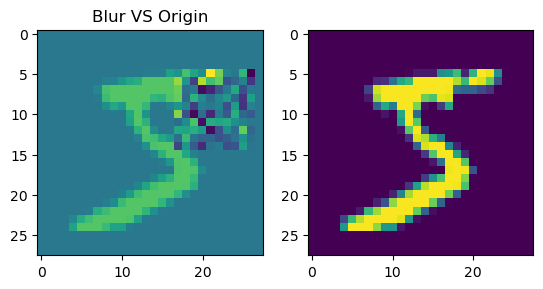

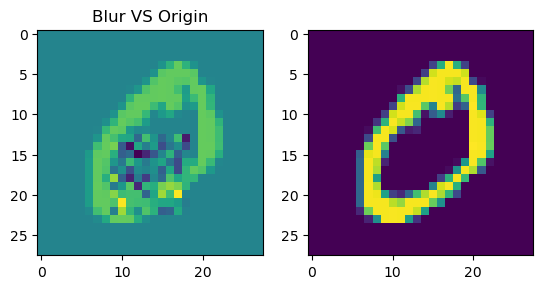

In [5]:
# torch.manual_seed(2023)
# Plot Blur VS origin 
for i in range(2):
    blur, orig  = modified_dataset[i]
    plt.subplot(1, 2, 1)
    plt.title("Blur VS Origin")
    plt.imshow(torch.squeeze(blur), )
    plt.subplot(1, 2, 2)
    plt.imshow(torch.squeeze(orig),)
    plt.show()

# AE Model Architecture 

In this denoising AE model, we use batchnorm to boost the learning performance. To further boost the performance, we can use Convolutional AE by adding Conv_layer. 

In [6]:
# Define a AE class for denosing 

# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(784, 256),
#             nn.ReLU(True),
#             nn.Linear(256, 64),
#             nn.ReLU(True),
#             nn.Linear(64, 32),
#             nn.ReLU(True),
#             nn.Linear(32, 16),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(16, 32),
#             nn.ReLU(True),
#             nn.Linear(32, 64),
#             nn.ReLU(True),
#             nn.Linear(64, 256),
#             nn.ReLU(True),
#             nn.Linear(256, 784),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [7]:
# # AE with Batch Norm
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),  # Batch Normalization added
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),  # Batch Normalization added
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),  # Batch Normalization added
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),  # Batch Normalization added
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),  # Batch Normalization added
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),  # Batch Normalization added
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),  # Batch Normalization added
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# define training dataset 
train_loader = torch.utils.data.DataLoader(dataset=modified_dataset, batch_size=batch_size, shuffle=True)

In [9]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda') 
autoencoder = AutoEncoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for (blur, orig) in train_loader:
        blur = blur.view(blur.size(0), -1).to(device)
        orig = orig.view(orig.size(0), -1).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(blur)
        loss = criterion(outputs, orig)
        loss.backward()
        optimizer.step()

    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, loss.item()))

Epoch [1/10], Loss: 0.0224
Epoch [2/10], Loss: 0.0197
Epoch [3/10], Loss: 0.0182
Epoch [4/10], Loss: 0.0169
Epoch [5/10], Loss: 0.0161
Epoch [6/10], Loss: 0.0155
Epoch [7/10], Loss: 0.0147
Epoch [8/10], Loss: 0.0142
Epoch [9/10], Loss: 0.0139
Epoch [10/10], Loss: 0.0137


Text(0.5, 1.0, 'Original')

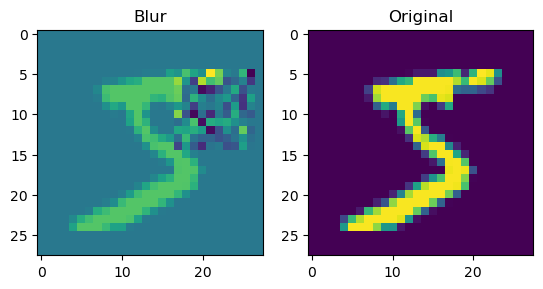

In [10]:
# create a blur image 
test_blur, test_orig = modified_dataset[0]
plt.subplot(1,2,1)
plt.imshow(torch.squeeze(test_blur))
plt.title('Blur')
plt.subplot(1,2,2)
plt.imshow(torch.squeeze(test_orig)) 
plt.title("Original")

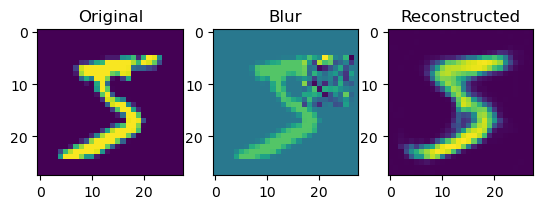

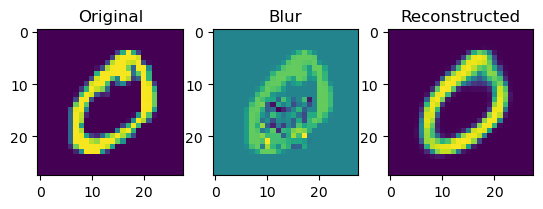

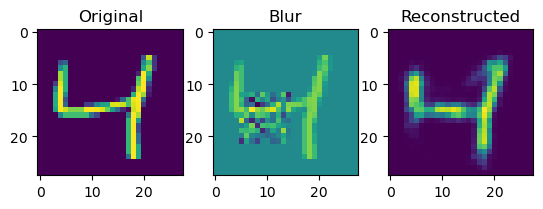

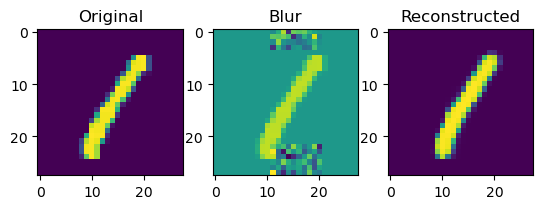

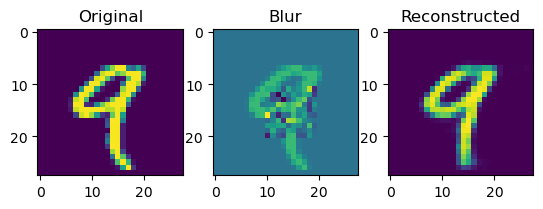

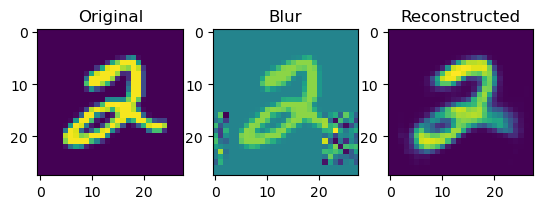

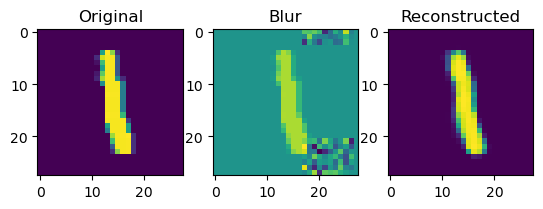

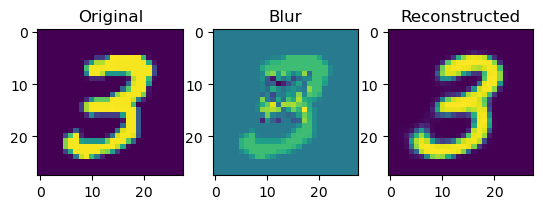

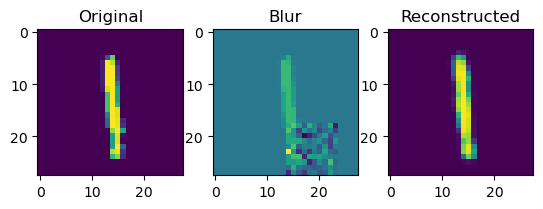

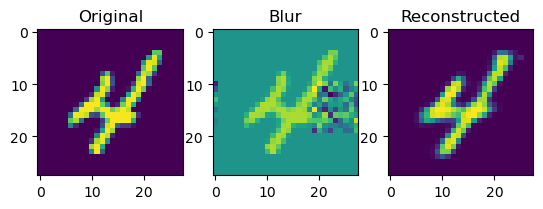

In [12]:
# try to recover blur 
autoencoder.eval()
for i in range(10):
    test_blur, test_orig = modified_dataset[i]
    with torch.no_grad():
        test_blur = test_blur.view(test_blur.size(0), -1).to(device)
        reconstructed = autoencoder(test_blur)

    reconstructed = reconstructed.view(28, 28)
    plt.subplot(1,3,1)
    plt.imshow(test_orig.view(28,28).cpu())
    plt.title('Original')
    plt.subplot(1,3,2)
    plt.imshow(test_blur.view(28,28).cpu())
    plt.title('Blur')
    plt.subplot(1,3,3)
    plt.imshow(torch.squeeze( reconstructed).cpu() ) 
    plt.title('Reconstructed')
    plt.show()